# Week 4 Problem 1

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select *Kernel*, and restart the kernel and run all cells (*Restart & Run all*).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select *File* → *Save and CheckPoint*)

5. When you are ready to submit your assignment, go to *Dashboard* → *Assignments* and click the *Submit* button. Your work is not submitted until you click *Submit*.

6. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

# Due Date: 6 PM, February 12, 2018

In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from nose.tools import assert_equal, assert_true, assert_almost_equal, assert_is_instance, assert_is_not
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score

# We do this to ignore several specific warnings
import warnings
warnings.filterwarnings("ignore")

## HELPER CODE TO GENERATE LEARNING CURVES
def get_range(trn_szs, trn_scr, tst_scr):
    '''
    Returns the ranges of the training and testing data needed for plotting a learn curve
    
    Parameters
    ----------
    trn_szs: A numpy ndarray
    trn_scr: A numpy ndarray
    tst_scr: A numpy ndarray
    
    Returns
    -------
    A 6-tuple of numpy.ndarrays of trn_scr_mu, trn_high, trn_low, trn_scr_mu, tst_high, tst_low
    '''
        
    trn_scr_mu = np.mean(trn_scr, axis=1)
    trn_scr_sig = np.std(trn_scr, axis=1)

    trn_high = np.array(trn_scr_mu) + np.array(trn_scr_sig)
    trn_low = np.array(trn_scr_mu) - np.array(trn_scr_sig)

    tst_scr_mu = np.mean(tst_scr, axis=1)
    tst_scr_sig = np.std(tst_scr, axis=1)

    tst_high = np.array(tst_scr_mu) + np.array(tst_scr_sig)
    tst_low = np.array(tst_scr_mu) - np.array(tst_scr_sig)
        
    return(trn_scr_mu, trn_high, trn_low, tst_scr_mu, tst_high, tst_low)


def lv_plot(ttle, x, y1, y1h, y1l, y2, y2h, y2l, xlbl, ylbl, ylim=None):
    '''
    Returns a matplotlib.Axes instance that plots the learning curve
    
    Parameters
    ----------
    ttle: string
    x: A numpy ndarray
    y1: A numpy ndarray
    y1h: A numpy ndarray
    y1l: A numpy ndarray
    y2: A numpy ndarray
    y2h: A numpy ndarray
    y2l: A numpy ndarray
    xlbl: string
    ylbl: string
    ylim: tuple of floats
    
    
    Returns
    -------
    ax: A matplotlib.Axes instance.
    '''
        
    # Plot the results
    fig, ax = plt.subplots(figsize=(10,8))

    trn_color = color=sns.xkcd_rgb["denim blue"]
    ax.plot(x, y1, label="Training Score", marker='d', lw=3, color=trn_color)
    ax.fill_between(x, y1h, y1l, alpha=0.25, color=trn_color)

    tst_color = color=sns.xkcd_rgb["medium green"]
    ax.plot(x, y2, label="CV Score", marker='d', lw=3, color=tst_color)
    ax.fill_between(x, y2h, y2l, alpha=0.25, color=tst_color)

    # Decorate plot
    ax.set(title=ttle, xlabel=xlbl, ylabel=ylbl)

    if ylim is not None:
        ax.set_ylim(*ylim)
        
    ax.legend(loc='best', borderaxespad=1.5)
    sns.despine(offset=10, trim=True)
    
    return ax

## Diabetes Dataset
For this assignment we will be using the built-in dataset about diabetes and the respective information on indivudal diabetes cases. This dataset has 442 samples and a dimensionality size of 10. In this assignment, we will be using the various attributes and Logistic Regression in order to create a model that we will tune and improve using cross-validation. Throughout the assignment, we will be improving our model from one that is very naïve to a more complicated one that accounts for all the attributes in the given dataset. 

The following code below imports the dataset as a pandas dataframe and previews a few sample data points.

In [2]:
'''
NOTE: Make sure to load this data set before completing the assignment
'''
columns = "age sex bmi map tc ldl hdl tch ltg glu".split()
# Load in the dataset as a Pandas DataFrame
data = load_diabetes()
data_df = pd.DataFrame(data.data, columns=columns)
# Preview the first few lines
data_df.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


## Question 0 - Separate into training and testing data

In this question, use the `data_df_clean` and the `labels` variables in order to separate the dataset into testing and training data using `train_test_split`.

- Set the test size to 0.3
- Set the random state to 23
- Name the return values from `train_test_split` as (d_train, d_test, l_train, l_test)

In [3]:
'''
Separate the dataset into training and testing data using the `train_test_split` function.
The testing and training data will be used in all the successive questions so make sure to finish this
question before proceeding to the other questions.

- Set the test size to 0.3
- Set the random_state to 23
- Use data_df_clean and labels variables below as parameters to the `train_test_split` function
'''

data_df_clean = data_df[data_df.columns[:-1]]
labels = data.target
# YOUR CODE HERE
d_train, d_test, l_train, l_test = train_test_split(data_df_clean, labels, \
                            test_size=0.3, random_state=23)

In [4]:
assert_true(d_train is not None)
assert_true(d_test is not None)
assert_true(l_train is not None)
assert_true(l_test is not None)

## Question 1 - Create Model and Score using K-fold

In this question, create a LinearRegression model and fit the data using the training data from above. In addition, you will need to cross-validate this model using the K-fold strategy.

- The function takes in a integer parameter `cv`, this will be the value passed into when scoring the model.
- Return a 2-tuple of the fitted model and scores in the function
- Use `cross_val_score` function in order to score the model with the `data` and the `labels`

In [5]:
def score_kfold(cv, data, labels):
    '''
    Creates a LinearRegression model and scores it using
    K-fold cross-validation
    
    Parameters
    ----------
    cv: An integer.
    data: A numpy ndarray
    labels: A numpy ndarray
    
    Returns
    -------
    A 2-tuple of the LinearRegression object and the cross-validation scores.
    '''
    # YOUR CODE HERE
    model = LinearRegression()
    model = model.fit(data, labels)
    scores = cross_val_score(model, data, labels, cv=cv)
    
    return model, scores

    
    

In [6]:
assert_true(isinstance(score_kfold(6, data.data, labels)[0], LinearRegression))
assert_true(isinstance(score_kfold(6, data.data, labels)[1], np.ndarray))
assert_equal(len(score_kfold(6, data.data, labels)[1]), 6)
assert_almost_equal(score_kfold(6, data.data, labels)[1][5], 0.569, places=3)

In [7]:
# Create a model with k-fold=3 (should not actually alter the model) so that we can use it to score
# based on alternative cross-validation strategies
# MAKE SURE TO RUN THIS CELL BEFORE PROCEEDING TO THE NEXT 2 QUESTIONS
model = score_kfold(3, data.data, labels)[0]

## Question 2 - Score using StratifiedKFold

In this question, we will be using our model that was created above, but we will be using a different cross-validation strategy, namely the StratifiedKFold strategy.

- The function takes in a integer parameter `n_splits`, this will be the value passed into the StratifiedKFold constructor when scoring the model.
- Use a `random_state` of 23 for the StratifiedKFold constructor
- Return a 2-tuple of the StratifiedKFold object and the numpy array of the scores.
- Use `cross_val_score` function in order to score the model with the `data` and the `labels`

In [8]:
def score_stratified_kfold(n_splits, data, labels):
    '''
    Score our previous model using the StratifiedKFold strategy
    
    Parameters
    ----------
    n_splits: An integer
    data: A numpy ndarray
    labels: A numpy ndarray
    
    Returns
    -------
    2-tuple of the StratifiedKFold object and the numpy array of the scores
    '''
    
    # YOUR CODE HERE
    skf = StratifiedKFold(n_splits=n_splits, random_state=23)
    scores = cross_val_score(model, data, labels, cv=skf)
    
    return skf, scores

In [9]:
assert_true(isinstance(score_stratified_kfold(2, data.data, labels)[0], StratifiedKFold))
assert_true(isinstance(score_stratified_kfold(2, data.data, labels)[1], np.ndarray))
assert_equal(len(score_stratified_kfold(2, data.data, labels)[1]), 2)
assert_almost_equal(score_stratified_kfold(2, data.data, labels)[1][1], 0.436, places=3)

## Question 3 - Generate a Learning Curve

In this question, we will be creating a learning curve from our LinearRegression model that we have created earlier. 

- Use a StratifiedKFold cross validation starategy with `n_splits=5` and `random_state=23`
- Generate 30 points from 0.1 to 1.0 as the training size. These points should be evenly spaced.
- The y-axis should range from 0.0 to 0.7
- Your plot should have a title
- Use the `learning_curve` function in order to retrieve the `training_sizes`, `training_scores`, and `valid_scores` from the model and the StratifiedKFold cross-validation strategy.
- You should make use of the functions `get_range` and `lv_plot` in the import code cell at the beginning of the notebook. The functions have docstrings that contain the order of parameters and the specific types expected.
- Return the result of the function call to `lv_plot`

In [10]:
def generate_learning_curve(data, labels):
    '''
    Generate a Learning Curve for the LinearRegression model from above.
    
    Parameters
    ----------
    data: A numpy ndarray
    labels: A numpy ndarray
    
    Returns
    -------
    ax: A matplotlib.Axes instance.
    '''
    
    # YOUR CODE HERE
    skf = StratifiedKFold(n_splits=5, random_state=23)
    trn_sz = np.linspace(0.1, 1, 30)
    
    trn_szs, trn_scr, vld_scr = \
        learning_curve(model, data, labels, cv=skf, train_sizes=trn_sz)
    
    y1, y1h, y1l, y2, y2h, y21 = get_range(trn_szs, trn_scr, vld_scr)
    
    title = 'Learning Curve with Linear Regression'
    ax = lv_plot(title, trn_szs, y1, y1h, y1l, y2, y2h, y21, 'Training Size', 'Score', ylim=(0.0, 0.7))
    
    return ax

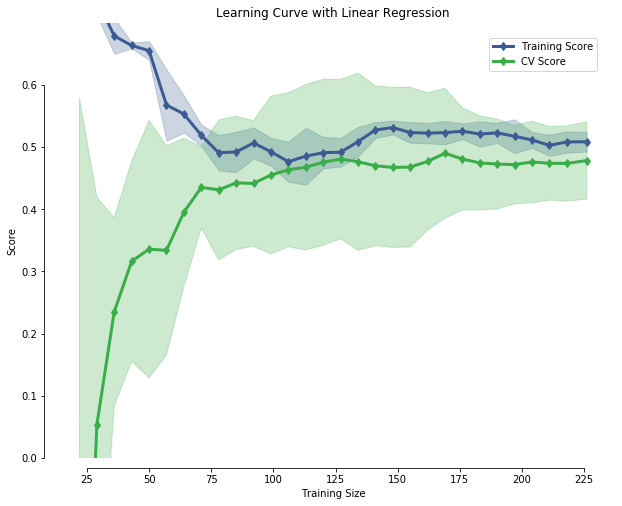

In [11]:
ax = generate_learning_curve(data.data, labels)

# Check if the title is set
assert_is_not(
    len(ax.title.get_text()), 0,
    msg="Your plot doesn't have a title."
)

# Check the y-axis limit
assert_equal(ax.get_ylim(), (0,0.7),
             msg="Change the y-axis limit to be (0,0.7)"
)

# Check the numbers of ROC curves plotted
assert_equal(len(ax.lines), 2,
             msg="Make sure to plot the 2 plot lines for the two types of data.")
